#RQ : 와인의 평점(Rating)을 예측하기 위한 데이터 전처리

## 활용 기법
###1. EDA
###2. Data Partitioning - train, valid, test
###3. DataModification - Log Transformation
###4. DataModification - Categorical encoding




##Google Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##0. Data Description

Kaggle에서 다운받은 데이터 vivino_top_ten.csv 의 경우 columns 중 'Year' 데이터 중 일부 N.V.를 제외하고도 공백인 Observation이 존재했고, 이 공백을 N.V.로 변환 후 새로 저장한 vivino_top_ten_revised.csv를 불러온다.

(https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data-top-10-countries-exchina)



In [ ]:
import pandas as pd
wine = '/content/drive/Shareddrives/22-1 데이터마이닝/vivino_top_ten_revised.csv'
wine_data_origin = pd.read_csv(wine) # original dataset

In [ ]:
wine_data_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Winery         12205 non-null  object 
 1   Year           12205 non-null  object 
 2   Wine_ID        12205 non-null  int64  
 3   Wine           12205 non-null  object 
 4   Rating         12205 non-null  float64
 5   Reviews        12205 non-null  int64  
 6   Price          12205 non-null  float64
 7   Region         12205 non-null  object 
 8   Primary_Grape  12205 non-null  object 
 9   Natural        12205 non-null  bool   
 10  Country        12205 non-null  object 
 11  Style          12205 non-null  object 
 12  Country_Code   12205 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 1.1+ MB


In [ ]:
# data deep copy
# wine_data_origin 을 보존
wine_data = wine_data_origin.copy() 

## 1. 결측치 및 Training에 불필요한 Column(s) 제거
target : 'Rating'

###1.1 결측치(N.V.) 없는 Dataset **만들기**
'Year'는 와인에 사용되는 포도의 품질을 결정할 수 있는 요소 중 하나이다. 하지만 N.V.값의 경우 평균, 중앙값, 혹은 최빈값 등으로 대체하게 되면 오히려 해당 특성에 대한 Noise로 작용할 수 있기 때문에 dataset에서 drop하였다.

In [ ]:
nullValueIndex = wine_data[wine_data.Year == 'N.V.'].index

# print(type(nullValueIndex))
# <class 'pandas.core.indexes.numeric.Int64Index'>

wine_data = wine_data.drop(nullValueIndex, axis=0)

wine_data.info() # check : 12206 -> 11298로 908개의 rows 삭제

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11298 entries, 0 to 12204
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Winery         11298 non-null  object 
 1   Year           11298 non-null  object 
 2   Wine_ID        11298 non-null  int64  
 3   Wine           11298 non-null  object 
 4   Rating         11298 non-null  float64
 5   Reviews        11298 non-null  int64  
 6   Price          11298 non-null  float64
 7   Region         11298 non-null  object 
 8   Primary_Grape  11298 non-null  object 
 9   Natural        11298 non-null  bool   
 10  Country        11298 non-null  object 
 11  Style          11298 non-null  object 
 12  Country_Code   11298 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 1.1+ MB


###1.2 중복되는 의미를 갖는 Featrue 제거하기
- 'Wine_ID'와 'Wine'의 경우 feature를 나타내는 column이 아닌 특정 물건을 지정하는 unique한 값을 갖는 column이므로 drop하였다.

- 'Region'의 경우 더 상위 개념에 해당하는 'Country_Code'라는 변수가 존재하기 때문에 모든 지역명을 숫자형으로 인코딩 했을 때 column의 개수가 과도하게 많아지는 상황을 방지하기 위해 drop하였다.

- 'Country'변수는 'Country_Code'변수와 사실상 동일한 의미를 가지고 있기 때문에 drop하였다.




- 결과적으로 memory usage가 약 0.3MB 감소하였다.

In [ ]:
wine_data = wine_data.drop(['Wine_ID', 'Wine', 'Region', 'Country'], axis=1)
wine_data.info() # memory usage 감소 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11298 entries, 0 to 12204
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Winery         11298 non-null  object 
 1   Year           11298 non-null  object 
 2   Rating         11298 non-null  float64
 3   Reviews        11298 non-null  int64  
 4   Price          11298 non-null  float64
 5   Primary_Grape  11298 non-null  object 
 6   Natural        11298 non-null  bool   
 7   Style          11298 non-null  object 
 8   Country_Code   11298 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 805.4+ KB


##2.Data Partitioning
총 데이터를 train : validation : test = 6 : 2 : 2 로 분할한다.

###2.1. 타겟 변수와 설명 변수로 데이터 셋 나누기

In [ ]:
y_data = wine_data.pop('Rating')
y_data = pd.DataFrame(y_data)
y_data.head()

,Rating
0,4.2
2,3.9
3,3.8
4,3.6
5,3.7


In [ ]:
x_data = wine_data
x_data.head()

,Winery,Year,Reviews,Price,Primary_Grape,Natural,Style,Country_Code
0,Baron de Ley,2020,42,7.15,Malbec,False,Rose,ARG
2,Alamos,2018,384,8.00,Malbec,False,Rose,ARG
3,Alamos,2019,820,8.00,Malbec,False,White,ARG
4,Alamos,2020,489,8.00,Malbec,False,Red,ARG
5,Alamos,2020,851,8.00,Malbec,False,White,ARG


In [ ]:
# 확인
print(x_data.shape)
print(y_data.shape)

(11298, 8)
(11298, 1)


###2.2 Train : Validation : Test = 6 : 2 : 2

In [ ]:
from sklearn.model_selection import train_test_split

# random_state=32 # memorize
# 1. train+valid set과 test set으로 분리
x_model, x_test, y_model, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=32)
# 2. train set과 validation set으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(x_model, y_model, test_size=0.25, random_state=32)

# train_data(x,y), validation_data(x,y), test_data(x,y)로 dataset 으로 합치기
train_data = pd.concat([x_train,y_train], axis=1)
valid_data = pd.concat([x_valid,y_valid], axis=1)
test_data = pd.concat([x_test,y_test], axis=1)

In [ ]:
# train, validation, test dataset의 shape 정보 출력 : 확인
print("{}의 shape : {}".format("train_data", train_data.shape))
print("{}의 shape : {}".format("valid_data", valid_data.shape))
print("{}의 shape : {}".format("test_data", test_data.shape))

train_data의 shape : (6778, 9)
valid_data의 shape : (2260, 9)
test_data의 shape : (2260, 9)


##3.Exploratory Data Analysis & Data Modification
- 수치형 데이터 시각화 후 Skewed 된 분포를 갖는 column의 데이터 scale 수정하기
- Boolean형 데이터 0 또는 1 값으로 변환
- Object형 데이터 탐색 후 One-Hot Encoding 적용

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

###3.1. Training Data에 대한 EDA

###3.1.1.수치형 데이터 탐색
- Log Transformation
- Outlier Detection : 

  보통의 Outlier값이라면 삭제해야 하지만 Wine에 대한 Rating을 반영하는 요소로 가격이 비싼 고급 와인의 경우 더 Rating이 높게 예측될 가능성이 있고, Review가 긴 경우도 소비자의 Rating에 영향을 미칠 가능성이 있다고 판단하여 제거하지 않았다. 

In [ ]:
# 수치형 데이터 탐색
train_data.describe()

,Reviews,Price,Rating
count,6778.000000,6778.000000,6778.000000
mean,318.843759,44.077417,3.926984
std,721.899150,130.893301,0.318101
min,25.000000,2.450000,2.700000
25%,53.000000,9.000000,3.700000
50%,114.000000,17.900000,3.900000
75%,286.750000,36.450000,4.200000
max,18483.000000,6511.310000,4.900000


In [ ]:
# 해당 Column내 데이터들의 분포 관련 통계량들을 확인한다.
# Review와 Price의 경우 skew값과 kurtosis 값이 크게 나타났다.
train_data[['Reviews', 'Price','Rating']].agg(['mean', 'std', 'skew', 'kurtosis', 'min', 'max'])

,Reviews,Price,Rating
mean,318.843759,44.077417,3.926984
std,721.899150,130.893301,0.318101
skew,7.925114,23.351749,0.069975
kurtosis,104.944946,954.577324,-0.203637
min,25.000000,2.450000,2.700000
max,18483.000000,6511.310000,4.900000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


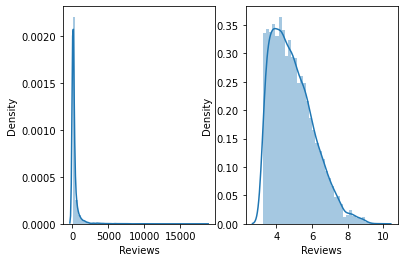

In [ ]:
fig, ax = plt.subplots(ncols=2)

sns.distplot(train_data['Reviews'], ax=ax[0])
sns.distplot(np.log1p(train_data['Reviews']), ax=ax[1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


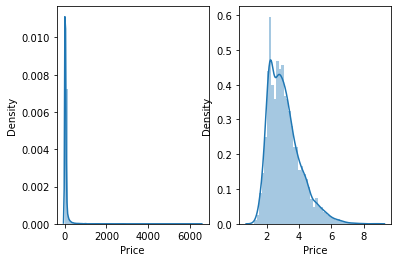

In [ ]:
fig, ax = plt.subplots(ncols=2)

sns.distplot(train_data['Price'], ax=ax[0])
sns.distplot(np.log1p(train_data['Price']), ax=ax[1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


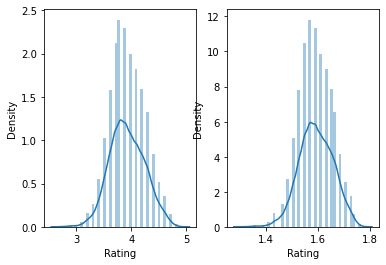

In [ ]:
fig, ax = plt.subplots(ncols=2)

sns.distplot(train_data["Rating"], ax=ax[0])
sns.distplot(np.log1p(train_data['Rating']), ax=ax[1])

In [ ]:
# Skewed 된 분포를 조정하는 작업
train_data['Reviews'] = np.log1p(train_data['Reviews'])
train_data['Price'] = np.log1p(train_data['Price'])
train_data.describe()

,Reviews,Price,Rating
count,6778.000000,6778.000000,6778.000000
mean,4.921698,3.105525,3.926984
std,1.160451,0.986969,0.318101
min,3.258097,1.238374,2.700000
25%,3.988984,2.302585,3.700000
50%,4.744932,2.939162,3.900000
75%,5.662091,3.623007,4.200000
max,9.824661,8.781450,4.900000


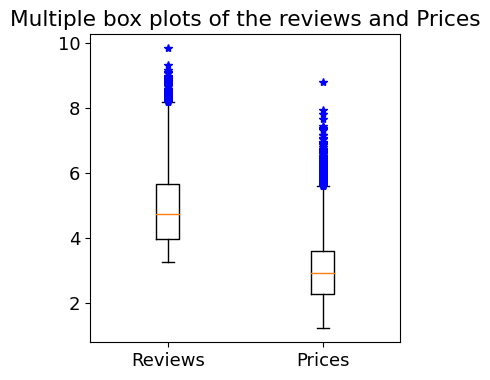

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([train_data['Reviews'], train_data['Price']], sym="b*")
plt.title('Multiple box plots of the reviews and Prices')
plt.xticks([1,2],
           ['Reviews', 'Prices'])
plt.show()

###3.1.2 Boolean Data to Int


In [ ]:
# Natural
train_data.Natural = train_data.Natural.replace({True: 1, False: 0})
train_data.head()

,Winery,Year,Reviews,Price,Primary_Grape,Natural,Style,Country_Code,Rating
1708,Wagner-Stempel,2016,5.327876,3.102342,Riesling,0,White,DEU,3.9
5925,Ayala,2006,5.918894,4.497251,Pinot Noir,0,Sparkling,FRA,4.4
7249,Biserno,2017,4.997212,5.093689,Sangiovese,0,Red,ITA,4.5
3005,Protos,2020,7.232010,2.008214,Tempranillo,0,White,ESP,3.8
4723,Château de Bois Brinçon,2018,3.465736,2.967847,Pinot Noir,0,White,FRA,3.8


###3.1.3 Object Type 데이터 탐색 및 One-hot encoding


In [ ]:
# Object Type Data 탐색
object_detect = train_data.select_dtypes(include=['object']).copy() # deep copy
object_detect.head()

,Winery,Year,Primary_Grape,Style,Country_Code
1708,Wagner-Stempel,2016,Riesling,White,DEU
5925,Ayala,2006,Pinot Noir,Sparkling,FRA
7249,Biserno,2017,Sangiovese,Red,ITA
3005,Protos,2020,Tempranillo,White,ESP
4723,Château de Bois Brinçon,2018,Pinot Noir,White,FRA


In [ ]:
# One-Hot Encoding
train_data = pd.get_dummies(train_data,
                            columns = ['Winery', 'Primary_Grape', 'Style', 'Country_Code'])

In [ ]:
train_data.head(3)

,Year,Reviews,Price,Natural,Rating,Winery_100 Hectares,Winery_19 Crimes,Winery_3 Ases,Winery_460 Casina Bric,Winery_47 Anno Domini,...,Country_Code_ARG,Country_Code_AUS,Country_Code_CHL,Country_Code_DEU,Country_Code_ESP,Country_Code_FRA,Country_Code_ITA,Country_Code_PRT,Country_Code_USA,Country_Code_ZAF
1708,2016,5.327876,3.102342,0,3.9,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5925,2006,5.918894,4.497251,0,4.4,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7249,2017,4.997212,5.093689,0,4.5,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Year 데이터를 Object -> Int로 변환하기
train_data = train_data.astype({'Year':int})
train_data.describe() # Year가 포함됨을 확인

,Year,Reviews,Price,Natural,Rating,Winery_100 Hectares,Winery_19 Crimes,Winery_3 Ases,Winery_460 Casina Bric,Winery_47 Anno Domini,...,Country_Code_ARG,Country_Code_AUS,Country_Code_CHL,Country_Code_DEU,Country_Code_ESP,Country_Code_FRA,Country_Code_ITA,Country_Code_PRT,Country_Code_USA,Country_Code_ZAF
count,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,...,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000,6778.000000
mean,2016.457805,4.921698,3.105525,0.038802,3.926984,0.000443,0.000885,0.000148,0.000148,0.000295,...,0.039097,0.036737,0.029065,0.088374,0.161995,0.153585,0.158011,0.132045,0.069785,0.131307
std,4.966353,1.160451,0.986969,0.193137,0.318101,0.021035,0.029742,0.012146,0.012146,0.017176,...,0.193840,0.188128,0.168000,0.283859,0.368473,0.360577,0.364778,0.338564,0.254802,0.337761
min,1911.000000,3.258097,1.238374,0.000000,2.700000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,3.988984,2.302585,0.000000,3.700000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.000000,4.744932,2.939162,0.000000,3.900000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,5.662091,3.623007,0.000000,4.200000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2021.000000,9.824661,8.781450,1.000000,4.900000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train_data.shape

(6778, 2841)

In [ ]:
# 최종 Training에 활용될 데이터들의 타입 확인
train_data.dtypes

Year                  int64
Reviews             float64
Price               float64
Natural               int64
Rating              float64
                     ...   
Country_Code_FRA      uint8
Country_Code_ITA      uint8
Country_Code_PRT      uint8
Country_Code_USA      uint8
Country_Code_ZAF      uint8
Length: 2841, dtype: object

In [ ]:
is_obj = train_data.select_dtypes(include=['object']).copy() # deep copy
is_obj.head() # obj객체가 모두 Training에 적합한 dtypes로 바뀌었음을 확인 가능

""
1708
5925
7249
3005
4723
